# Molecular Tastants
Bogna Kilanowska 148252

## Project decription
### Overview
In this challenge, students will leverage machine learning to predict the taste profile of molecules based on their chemical structure. Using the SMILES (Simplified Molecular Input Line Entry System) representation of molecules, the goal is to classify molecules into taste categories, such as Bitterness, Miscellaneous, Multitaste, Non-sweetness, Saltiness, Sourness, Sweetness, Tastelessness, and Umaminess.

### Task details
The student's task is to create an algorithm that predicts one of the above-mentioned tastes based on features extracted from molecular SMILES.

The task should be performed in Python.
To obtain features from SMILES, students may use RDKit, DeepChem, PySCF, or any other chemistry-related toolkit. Moreover, to create a predictive model, scikit-learn or any other machine learning toolkit can be utilized.

In addition to submitting the solution on this side, students are required to provide a link to reproducible code in the form of a Jupyter Notebook on the e-kursy platform. This project can be done in pairs (please, write your team name in the notebook).

https://www.kaggle.com/competitions/molecular-tastants


## Project setup

In [21]:
import numpy as np 

np.random.seed(973)

In [22]:
import pandas as pd

df = pd.read_csv('data/train.csv')
df.head()

,molecule_id,smiles,taste
0,train_0,C=C1CC23CCC4C(C)(C(=O)O)CCCC4(C)C2CCC1(OC1OC(C...,6
1,train_1,Nc1ccccc1NS(=O)(=O)[O-].[Na+],3
2,train_2,O=C1NS(=O)(=O)c2cc(O)ccc21,6
3,train_3,OCC1OC(Oc2ccc3ccccc3c2)C(O)C(O)C1O,0
4,train_4,CCC1(C2=CCCCCC2)C(=O)NC(=O)NC1=O,0


## Preliminary data analysis

Dataset contains information about chemical structures of 1809 molecules. For each molecule there is an integer (0-8) that encodes taste of the molecule. There are no NAs and no NULLs in the dataset. Dataset is highly imbalanced: among 1809 molecules, nearly 6/15 of them are labeled as bitter (0), 5/15 are labeled as sour (6) and barely 8 molecules are labeled as salty (4).

In [23]:
print(f'Data shape: {df.shape}')
print("\nNA count:")
print(df.isna().sum())
print("\nNULL count:")
print(df.isnull().sum())

Data shape: (1809, 3)

NA count:
molecule_id    0
smiles         0
taste          0
dtype: int64

NULL count:
molecule_id    0
smiles         0
taste          0
dtype: int64


taste
0    731
6    589
3    149
7    125
2     69
8     63
1     50
5     25
4      8
Name: count, dtype: int64


array([[<Axes: title={'center': 'taste'}>]], dtype=object)

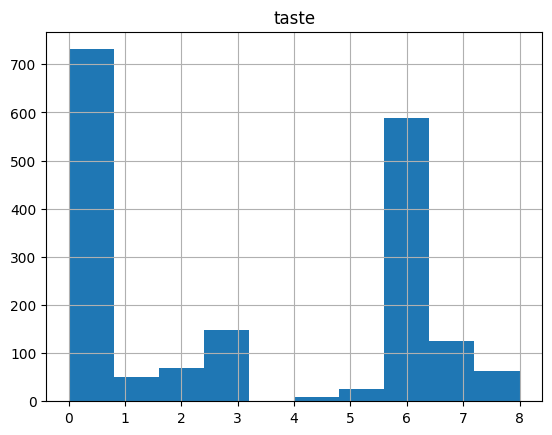

In [24]:
print(df.taste.value_counts())
df.hist(column='taste')

## Data pre-processing
Data pre-processing procedure consists of 3 steps.

Step 1: data are encoded by 166 public MACCS keys. `1` means that certain key is present for a molecule and `0` that it is absent.

Step 2: data are balanced using algorithm SMOTE which is an implementation of over-sampling procedure.

Step 3: feature engineering is performed in the dataset. Features with variance below a threshold are dropped.

### Data encoding

In [6]:
from rdkit.Chem import MACCSkeys
from rdkit import Chem

def get_maccs_fps(dataframe):
    maccs = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)) for x in dataframe['smiles']]
    maccs_lists = [list(l) for l in maccs]
    maccs_name = [f'MACCS_{i}' for i in range(167)]

    return pd.DataFrame(maccs_lists, index=dataframe.index, columns=maccs_name)

### Data balancing

In [7]:
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from collections import Counter

def balance_classes(X, y, info = True, sampling_strategy = 'auto', random_state = 973, k_neighbors = 5):
    sme = SMOTE(
        sampling_strategy=sampling_strategy,
        random_state = random_state,
        k_neighbors=k_neighbors)

    if info: print(f'Classes distribution before sampling : {sorted(Counter(y).items())}')
    X_resampled, y_resampled = sme.fit_resample(X, y)
    if info: print(f'Classes distribution after sampling: {sorted(Counter(y_resampled).items())}')

    return X_resampled, y_resampled

### Feature engineering

In [8]:
from sklearn.feature_selection import VarianceThreshold

def select_features(data, threshold = 0.05, info = True):
    
    if info: print(data.shape)
    selector = VarianceThreshold(threshold=threshold)
    selector.fit_transform(data)
    if info: print(data[data.columns[selector.get_support(indices=True)]].shape)

    return data[data.columns[selector.get_support(indices=True)]]

## Train test split
Data are encoded and splitted into training and testing sets with ratio 8:2.

In [9]:
from sklearn.model_selection import train_test_split

def train_test_split_data(X = df.smiles, y = df.taste, test_size=0.2, random_state=973):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print(f'Classes distribution train: {sorted(Counter(y_train).items())}')
    print(f'Classes distribution test: {sorted(Counter(y_test).items())}')

    return X_train, X_test, y_train, y_test 

In [25]:
X = get_maccs_fps(df)
y = df.taste

X_train, X_test, y_train, y_test = train_test_split_data(X, y, random_state=6)

Classes distribution train: [(0, 594), (1, 42), (2, 53), (3, 114), (4, 6), (5, 21), (6, 463), (7, 107), (8, 47)]
Classes distribution test: [(0, 137), (1, 8), (2, 16), (3, 35), (4, 2), (5, 4), (6, 126), (7, 18), (8, 16)]


## Model
Described problem is a problem of multi-class classification. To solve it, `RandomForestClassifier` is used as a machine learning model. The model is evaluated by balanced accuracy metric. Results are presented in a form of confusion matrix.

In [11]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def train_model(X_train, y_train, 
                n_estimators=100, 
                max_features='sqrt', 
                max_depth=None,
                min_samples_split=2,
                bootstrap=True):

    clf = RandomForestClassifier(
        random_state=0,
        n_estimators=n_estimators,
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        bootstrap=bootstrap
        )
    
    clf.fit(X_train, y_train)
    
    return clf

def make_prediction(clf, X_test):
    y_pred = clf.predict(X_test)

    return y_pred

def evaluate_model(y_test, y_pred, print_acc = True, show_cm = True, cm_labels = [0,1,2,3,4,5,6,7,8]):
    acc = balanced_accuracy_score(y_test, y_pred)

    if print_acc:
        print(f"Balanced accuracy: {acc:.2%}")

    if show_cm:
        cm = confusion_matrix(y_test, y_pred, labels = cm_labels)
        cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8])
        cm_display.plot()
        plt.show()

    return acc



## Visualisations

### Learning curves

In [42]:
from sklearn.model_selection import learning_curve

def show_learning_curves(data_X, classes_y, train_sizes = np.arange(0.1,1,0.05), cv = 5):
    clf = RandomForestClassifier(
            random_state=0)

    train_size_abs, train_scores, test_scores = learning_curve(
        estimator = clf, 
        X = data_X, y = classes_y, 
        train_sizes = train_sizes,
        cv = cv,
        scoring = 'balanced_accuracy'
    )

    train_scores_mean = train_scores.mean(axis = 1)
    test_scores_mean = test_scores.mean(axis = 1)

    plt.plot(train_size_abs, train_scores_mean, label = 'Training acc')
    plt.plot(train_size_abs, test_scores_mean, label = 'Test acc')
    plt.ylabel('Balanced acc', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves for a random forest classifier', fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,1)
    plt.show()

## Evaluation

In this section, performance of model with different combinations of pre-processing procedures is evaluated. 

Case 01: model is trained on encoded data.

Case 02: model is trained on encoded and balanced data.

Case 03: model is trained on encoded data, on which feature engineering is performed.

Case 04: model is trained on encoded and balanced data, on which feature engineering is performed.

### Case 01: model

Running model with default parameters on encoded data results in 62.22% balanced accuracy. Model has biggest problems with classifying molecules that true labels are `2` and `7`. It often misclassifies data with `7` label. Learning curve plot shows that there are too small amount of samples with respect to big number of features.

Balanced accuracy: 62.22%


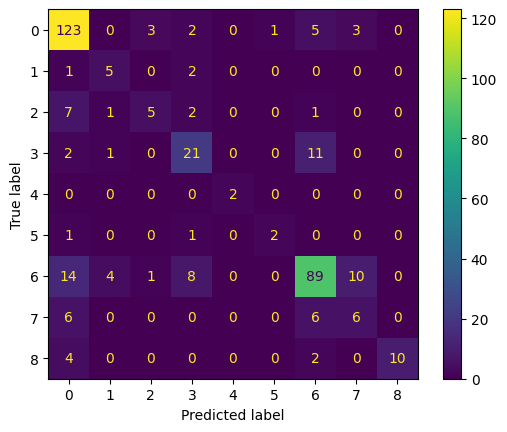

In [12]:
clf = train_model(X_train, y_train)
y_pred = make_prediction(clf, X_test)
acc = evaluate_model(y_test, y_pred)

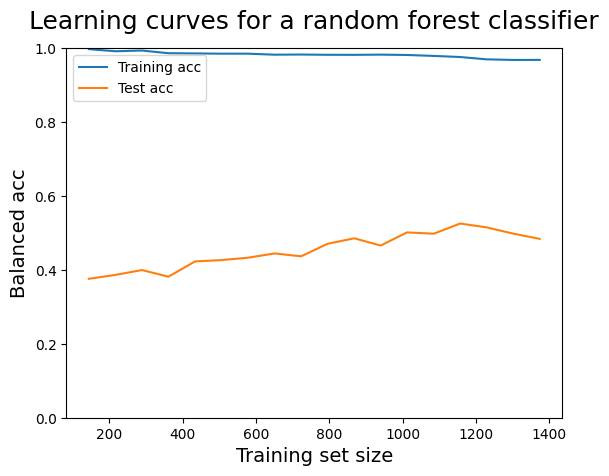

In [43]:
show_learning_curves(X, y)

### Case 02 balancing data + model

Running model with default parameters on encoded and balanced data results in balanced accuracy between 59.82% and 69.29%. Best scores model acomplishes for dataset balanced according to `not majority` sampling strategy with `k_neighbors` parameter equals to 5. Model has biggest problems with classifying molecules that true labels are `2`.It often misclassifies data with `7` label. Learning curve plot shows that enlarging number of samples by data augmentation improves learning. However it is tested on augmentated data - therefore results are overestimated.

Classes distribution before sampling : [(0, 594), (1, 42), (2, 53), (3, 114), (4, 6), (5, 21), (6, 463), (7, 107), (8, 47)]
Classes distribution after sampling: [(0, 594), (1, 594), (2, 594), (3, 594), (4, 594), (5, 594), (6, 594), (7, 594), (8, 594)]
Balanced accuracy: 69.29%


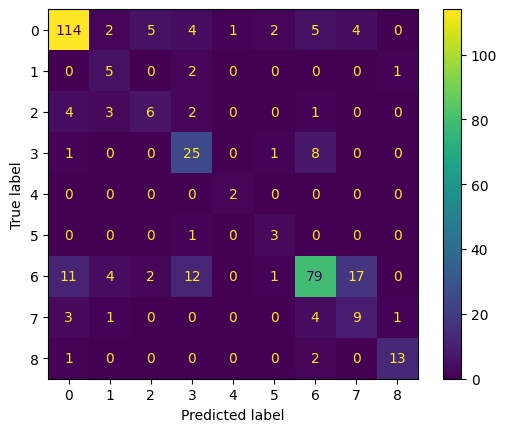

In [14]:
X_resampled, y_resampled = balance_classes(X_train, y_train, k_neighbors=5)

clf = train_model(X_resampled, y_resampled)
y_pred = make_prediction(clf, X_test)
acc = evaluate_model(y_test, y_pred)

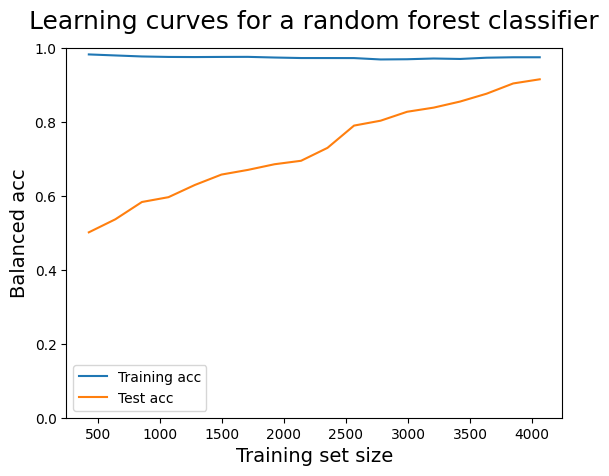

In [46]:
show_learning_curves(X_resampled, y_resampled)


Sampling strategy: minority
Min acc: 59.82%
Max acc: 62.66%
Avg acc: 61.26%

Sampling strategy: not minority
Min acc: 63.31%
Max acc: 67.99%
Avg acc: 66.28%

Sampling strategy: not majority
Min acc: 64.36%
Max acc: 69.29%
Avg acc: 67.48%

Sampling strategy: all
Min acc: 64.36%
Max acc: 69.29%
Avg acc: 67.48%


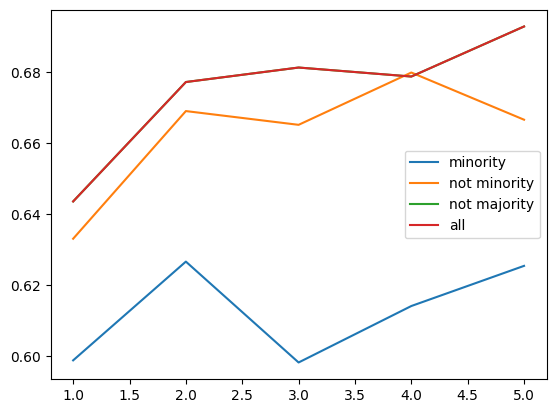

In [15]:
n_iterations = 10


sampling_strategy = ['minority', 'not minority', 'not majority', 'all']
k_neighbors = np.arange(1, 6, 1)

for s in sampling_strategy:
    
    acc_scores = []
    for k in k_neighbors:
        X_resampled, y_resampled = balance_classes(X_train, y_train, info = False, sampling_strategy=s, k_neighbors=k)

        clf = train_model(X_resampled, y_resampled)
        y_pred = make_prediction(clf, X_test)
        acc = evaluate_model(y_test, y_pred, print_acc = False, show_cm = False)

        acc_scores.append(acc)

    print(f'\nSampling strategy: {s}')
    print(f'Min acc: {min(acc_scores):.2%}')
    print(f'Max acc: {max(acc_scores):.2%}')
    print(f'Avg acc: {sum(acc_scores)/k_neighbors.size:.2%}')

    plt.plot(k_neighbors, acc_scores, label = s)

plt.legend()
plt.show()

### Case 03: feature engineering + model

Running model with default parameters on encoded data on which feature engineering was performed results in balanced accuracy between 47.58% and 64.26%. Best scores model acomplishes for variance threshold of 0.01. Model has biggest problems with classifying molecules that true labels are `2` and `7`. It often misclassifies data with `1` and `7` labels. Learning curve plot shows that smaller number of features does not bring meaningful improvement.

(1447, 167)
(1447, 140)
Balanced accuracy: 64.26%


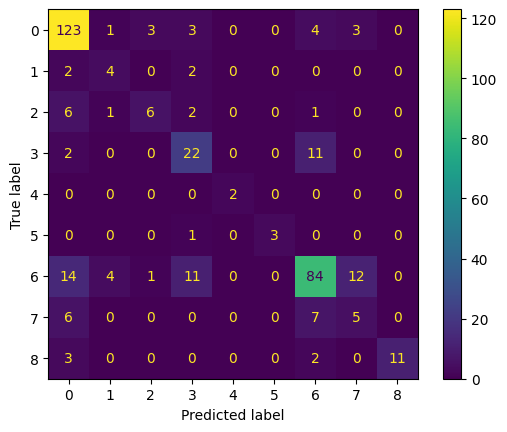

In [16]:
X_selected = select_features(pd.DataFrame(X_train), threshold = 0.01)
column_names = X_selected.columns
X_selected_test = X_test[column_names]

clf = train_model(X_selected, y_train)
y_pred = make_prediction(clf, X_selected_test)
acc = evaluate_model(y_test, y_pred)

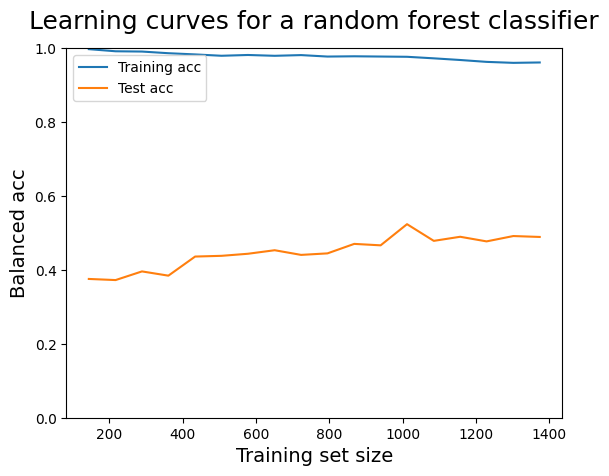

In [47]:
show_learning_curves(X[column_names], y)

Min acc: 47.58%
Max acc: 64.26%
Avg acc: 57.95%


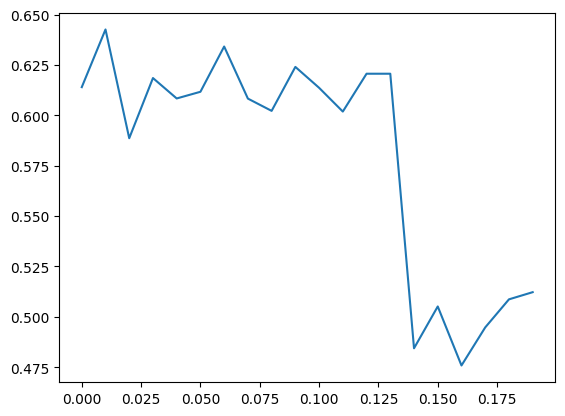

In [17]:
acc_scores = []
thresholds = np.arange(0, 0.2, 0.01)

for t in thresholds:
    X_selected = select_features(pd.DataFrame(X_train), threshold = t, info = False)
    column_names = X_selected.columns
    X_selected_test = X_test[column_names]

    clf = train_model(X_selected, y_train)
    y_pred = make_prediction(clf, X_selected_test)
    acc = evaluate_model(y_test, y_pred, print_acc = False, show_cm = False)

    acc_scores.append(acc)

print(f'Min acc: {min(acc_scores):.2%}')
print(f'Max acc: {max(acc_scores):.2%}')
print(f'Avg acc: {sum(acc_scores)/thresholds.size:.2%}')

plt.plot(thresholds, acc_scores)
plt.show() 

### Case 04: balancing data + feature engineering + model

Running model with default parameters on encoded and balanced data on which feature engineering was performed results in balanced accuracy between 49.47% and 69.91%. Best scores model acomplishes for dataset balanced with `k_neighbors` parameter equals to 4 and for variance threshold of 0.02. Model has biggest problems with classifying molecules that true labels are `2`.It often misclassifies data with `1`, `2`, and `7` labels. Learning curve plot shows that enlarging number of samples by data augmentation and performing feature extraction improves learning. However it is tested on augmentated data - therefore results are overestimated.

Classes distribution before sampling : [(0, 594), (1, 42), (2, 53), (3, 114), (4, 6), (5, 21), (6, 463), (7, 107), (8, 47)]
Classes distribution after sampling: [(0, 594), (1, 594), (2, 594), (3, 594), (4, 594), (5, 594), (6, 594), (7, 594), (8, 594)]
(5346, 167)
(5346, 130)
Balanced accuracy: 69.91%


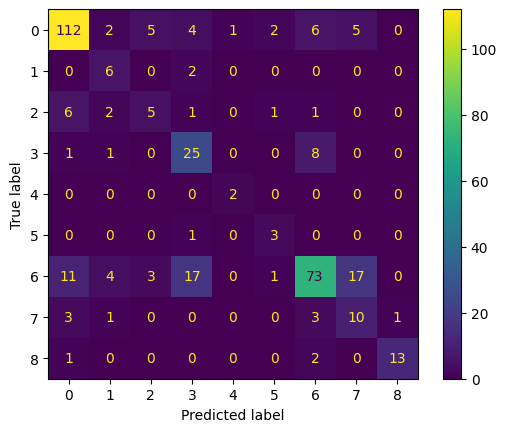

In [12]:
X_resampled, y_resampled = balance_classes(X_train, y_train, k_neighbors=4)

X_selected = select_features(pd.DataFrame(X_resampled), threshold = 0.02)
column_names = X_selected.columns
X_selected_test = X_test[column_names]

clf = train_model(X_selected, y_resampled)
y_pred = make_prediction(clf, X_selected_test)
acc = evaluate_model(y_test, y_pred)

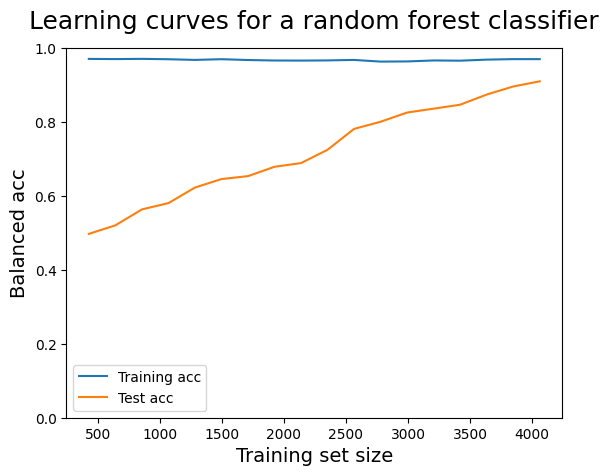

In [48]:
show_learning_curves(X_selected, y_resampled)


Threshold: 0.0
Min acc: 64.43%
Max acc: 68.09%
Avg acc: 66.32%

Threshold: 0.01
Min acc: 64.45%
Max acc: 68.37%
Avg acc: 66.79%

Threshold: 0.02
Min acc: 61.96%
Max acc: 69.91%
Avg acc: 66.56%

Threshold: 0.03
Min acc: 63.98%
Max acc: 69.16%
Avg acc: 67.10%

Threshold: 0.04
Min acc: 63.04%
Max acc: 68.31%
Avg acc: 66.90%

Threshold: 0.05
Min acc: 63.68%
Max acc: 68.72%
Avg acc: 67.22%

Threshold: 0.06
Min acc: 62.83%
Max acc: 67.82%
Avg acc: 66.38%

Threshold: 0.07
Min acc: 55.53%
Max acc: 68.80%
Avg acc: 64.21%

Threshold: 0.08
Min acc: 64.73%
Max acc: 69.47%
Avg acc: 67.22%

Threshold: 0.09
Min acc: 65.14%
Max acc: 69.15%
Avg acc: 67.12%

Threshold: 0.1
Min acc: 56.80%
Max acc: 67.82%
Avg acc: 65.13%

Threshold: 0.11
Min acc: 53.01%
Max acc: 68.93%
Avg acc: 62.84%

Threshold: 0.12
Min acc: 53.73%
Max acc: 70.79%
Avg acc: 63.96%

Threshold: 0.13
Min acc: 53.73%
Max acc: 70.06%
Avg acc: 63.54%

Threshold: 0.14
Min acc: 53.31%
Max acc: 68.03%
Avg acc: 61.79%

Threshold: 0.15
Min acc: 5

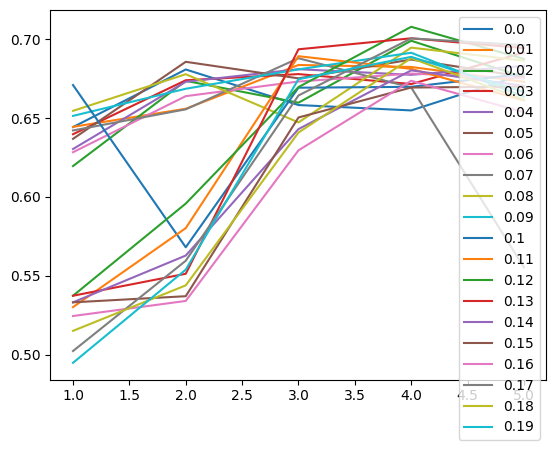

In [13]:
acc_scores = []

sampling_strategy = ['minority', 'not minority', 'not majority', 'all']
k_neighbors = np.arange(1, 6, 1)
thresholds = np.arange(0, 0.2, 0.01)

for t in thresholds:
    acc_scores = []
    for k in k_neighbors:
        X_resampled, y_resampled = balance_classes(X_train, y_train, info = False, sampling_strategy='not majority', k_neighbors=k)

        X_selected = select_features(pd.DataFrame(X_resampled), threshold = t, info = False)
        column_names = X_selected.columns
        X_selected_test = X_test[column_names]

        clf = train_model(X_selected, y_resampled)
        y_pred = make_prediction(clf, X_selected_test)
        acc = evaluate_model(y_test, y_pred, print_acc = False, show_cm = False)

        acc_scores.append(acc)

    print(f'\nThreshold: {t}')
    print(f'Min acc: {min(acc_scores):.2%}')
    print(f'Max acc: {max(acc_scores):.2%}')
    print(f'Avg acc: {sum(acc_scores)/k_neighbors.size:.2%}')

    plt.plot(k_neighbors, acc_scores, label = t)

plt.legend()
plt.show() 

### Comment on learning curves

I am aware that conclusion from learning curves plots could be that percentage of data that is included in train set should increase to 0.9 or even 0.95. However, I want to once more sress out, that those learning curves were computed from dataset created from augemntating traing data. From the one hand, increasing percentage of samples in train dataset before data augmentation will mostly probably result in lack of representation of minority classes in test dataset. From the other hand, I do not want to perform train test split on dataset after augmentation, because I prefer to not add artificial data to test dataset - It may results in overestimated results (same as it take place in learning curves visualizations).

## Hyperparameter tuning

There were two attempts to models's hyperparameter tuning. However both end with parameters values on which model performs worse than on default parameters. 

During attempt 01 this may be caused by not relevant performance estimation during grid search with cross validation. The cross validation is performed on training set that is after classes over-sampling. In result, test set mostly contains artificial created data, that are easier to classify than original data. This results in overestimation of models performance.

During attempt 02 model was trained on original, imbalanced data. It gives more realistic results, however parameters on which model was trained still do not apply well to model that is trained on pre-processed dataset.

### Attempt 01: hyperparameter tuning on balanced dataset

In [ ]:
from sklearn.model_selection import GridSearchCV

X_resampled, y_resampled = balance_classes(X_train, y_train, k_neighbors=4)

X_selected = select_features(pd.DataFrame(X_resampled), threshold = 0.02)
column_names = X_selected.columns
X_selected_test = X_test[column_names]

parameters = {
    'n_estimators':(100, 200, 300),
    'max_features':('log2', 'sqrt'),
    'max_depth': (None,100,300,500,700),
    'min_samples_split': (2,3,4,5,6),
    'bootstrap': [True, False],
    'random_state': [0]
    }

grid_search = GridSearchCV(RandomForestClassifier(),
                           scoring='balanced_accuracy', 
                           param_grid=parameters,
                           verbose=2) 

grid_search.fit(X_selected, y_resampled)

        # n_estimators=300,
        # max_features='log2',
        # max_depth=100,
        # min_samples_split=7,
        # bootstrap=False

In [36]:
pd.DataFrame(grid_search.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
221,2.514479,0.092276,0.114789,0.011340,False,300,log2,5,300,0,"{'bootstrap': False, 'max_depth': 300, 'max_fe...",0.851374,0.929015,0.928943,0.925992,0.935424,0.914150,0.031538,1
281,2.637272,0.128735,0.122233,0.005504,False,700,log2,5,300,0,"{'bootstrap': False, 'max_depth': 700, 'max_fe...",0.851374,0.929015,0.928943,0.925992,0.935424,0.914150,0.031538,1
161,2.436673,0.132767,0.110744,0.011133,False,None,log2,5,300,0,"{'bootstrap': False, 'max_depth': None, 'max_f...",0.851374,0.929015,0.928943,0.925992,0.935424,0.914150,0.031538,1
251,2.502137,0.104018,0.116566,0.011702,False,500,log2,5,300,0,"{'bootstrap': False, 'max_depth': 500, 'max_fe...",0.851374,0.929015,0.928943,0.925992,0.935424,0.914150,0.031538,1
191,2.394009,0.035071,0.106354,0.002996,False,100,log2,5,300,0,"{'bootstrap': False, 'max_depth': 100, 'max_fe...",0.851374,0.929015,0.928943,0.925992,0.935424,0.914150,0.031538,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,2.234712,0.062104,0.092589,0.003885,True,None,sqrt,6,300,0,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.844831,0.917770,0.914004,0.912849,0.926008,0.903092,0.029493,296
59,2.348795,0.190415,0.099768,0.010571,True,100,sqrt,6,300,0,"{'bootstrap': True, 'max_depth': 100, 'max_fea...",0.844831,0.917770,0.914004,0.912849,0.926008,0.903092,0.029493,296
89,2.333840,0.153177,0.097111,0.005099,True,300,sqrt,6,300,0,"{'bootstrap': True, 'max_depth': 300, 'max_fea...",0.844831,0.917770,0.914004,0.912849,0.926008,0.903092,0.029493,296
119,2.614863,0.173806,0.110828,0.016151,True,500,sqrt,6,300,0,"{'bootstrap': True, 'max_depth': 500, 'max_fea...",0.844831,0.917770,0.914004,0.912849,0.926008,0.903092,0.029493,296


In [39]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='log2',
                       min_samples_split=5, n_estimators=300, random_state=0)

Classes distribution before sampling : [(0, 594), (1, 42), (2, 53), (3, 114), (4, 6), (5, 21), (6, 463), (7, 107), (8, 47)]
Classes distribution after sampling: [(0, 594), (1, 594), (2, 594), (3, 594), (4, 594), (5, 594), (6, 594), (7, 594), (8, 594)]
(5346, 167)
(5346, 130)
Balanced accuracy: 66.22%


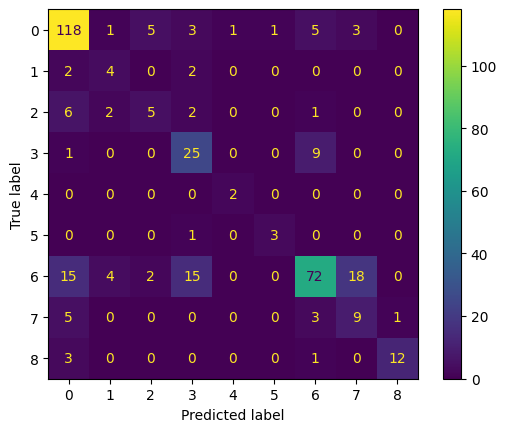

In [40]:
X_resampled, y_resampled = balance_classes(X_train, y_train, k_neighbors=4)

X_selected = select_features(pd.DataFrame(X_resampled), threshold = 0.02)
column_names = X_selected.columns
X_selected_test = X_test[column_names]

clf = train_model(X_selected, y_resampled,
                  bootstrap=False, max_features='log2',
                       min_samples_split=5, n_estimators=300)
y_pred = make_prediction(clf, X_selected_test)
acc = evaluate_model(y_test, y_pred)

### Attempt 02: hyperparameter tuning on imbalanced dataset

In [33]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators':(100, 200, 300),
    'max_features':('log2', 'sqrt'),
    'max_depth': (None,100,300,500,700),
    'min_samples_split': (2,3,4,5,6),
    'bootstrap': [True, False],
    'random_state': [0]
    }

grid_search_2 = GridSearchCV(RandomForestClassifier(),
                           scoring='balanced_accuracy', 
                           param_grid=parameters,
                           verbose=2) 

grid_search_2.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_split=2, n_estimators=100, random_state=0; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_split=2, n_estimators=100, random_state=0; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_split=2, n_estimators=100, random_state=0; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_split=2, n_estimators=100, random_state=0; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_split=2, n_estimators=100, random_state=0; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_split=2, n_estimators=200, random_state=0; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_split=2, n_estimators=200, random_state=0; total time=   0.9

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': (None, 100, 300, 500, 700),
                         'max_features': ('log2', 'sqrt'),
                         'min_samples_split': (2, 3, 4, 5, 6),
                         'n_estimators': (100, 200, 300), 'random_state': [0]},
             scoring='balanced_accuracy', verbose=2)

In [34]:
pd.DataFrame(grid_search_2.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
256,1.374059,0.097186,0.038823,0.009804,False,500,sqrt,2,200,0,"{'bootstrap': False, 'max_depth': 500, 'max_fe...",0.453204,0.448764,0.370938,0.511640,0.576485,0.472206,0.068695,1
196,1.343466,0.038348,0.033811,0.001716,False,100,sqrt,2,200,0,"{'bootstrap': False, 'max_depth': 100, 'max_fe...",0.453204,0.448764,0.370938,0.511640,0.576485,0.472206,0.068695,1
226,1.351004,0.045194,0.034607,0.003257,False,300,sqrt,2,200,0,"{'bootstrap': False, 'max_depth': 300, 'max_fe...",0.453204,0.448764,0.370938,0.511640,0.576485,0.472206,0.068695,1
286,1.367249,0.041935,0.032995,0.001894,False,700,sqrt,2,200,0,"{'bootstrap': False, 'max_depth': 700, 'max_fe...",0.453204,0.448764,0.370938,0.511640,0.576485,0.472206,0.068695,1
166,1.721412,0.208056,0.045515,0.008280,False,None,sqrt,2,200,0,"{'bootstrap': False, 'max_depth': None, 'max_f...",0.453204,0.448764,0.370938,0.511640,0.576485,0.472206,0.068695,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,0.871593,0.013959,0.043601,0.000485,True,500,log2,6,300,0,"{'bootstrap': True, 'max_depth': 500, 'max_fea...",0.371051,0.376615,0.363374,0.397821,0.376346,0.377041,0.011447,296
134,0.861733,0.011022,0.045963,0.002321,True,700,log2,6,300,0,"{'bootstrap': True, 'max_depth': 700, 'max_fea...",0.371051,0.376615,0.363374,0.397821,0.376346,0.377041,0.011447,296
14,0.900290,0.011747,0.045818,0.002493,True,None,log2,6,300,0,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.371051,0.376615,0.363374,0.397821,0.376346,0.377041,0.011447,296
44,0.911220,0.032844,0.043551,0.000440,True,100,log2,6,300,0,"{'bootstrap': True, 'max_depth': 100, 'max_fea...",0.371051,0.376615,0.363374,0.397821,0.376346,0.377041,0.011447,296


In [37]:
grid_search_2.best_estimator_

RandomForestClassifier(bootstrap=False, n_estimators=200, random_state=0)

Classes distribution before sampling : [(0, 594), (1, 42), (2, 53), (3, 114), (4, 6), (5, 21), (6, 463), (7, 107), (8, 47)]
Classes distribution after sampling: [(0, 594), (1, 594), (2, 594), (3, 594), (4, 594), (5, 594), (6, 594), (7, 594), (8, 594)]
(5346, 167)
(5346, 130)
Balanced accuracy: 67.76%


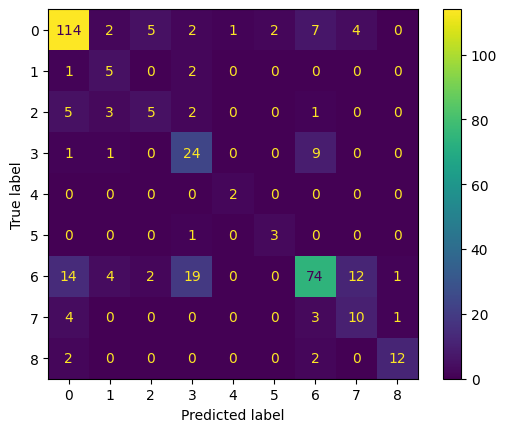

In [20]:
X_resampled, y_resampled = balance_classes(X_train, y_train, k_neighbors=4)

X_selected = select_features(pd.DataFrame(X_resampled), threshold = 0.02)
column_names = X_selected.columns
X_selected_test = X_test[column_names]

clf = train_model(X_selected, y_resampled,
                  bootstrap=False, max_features='sqrt',
                       min_samples_split=2, n_estimators=200)
y_pred = make_prediction(clf, X_selected_test)
acc = evaluate_model(y_test, y_pred)

## Looking for a better train test split for training

Yeah, definetly I am not proud of this section, however ironically it brings greatest improvement in final results. My theory is that for dataset in which there are some classes that are so dramaticly underrepresented, it is crutial to carefully choose representans to oversampling. I could do that by exhaustive search or by insightful analysis, nevertheless I decided to use simpler and faster method that is random search implemented by evaluating model after train_test_split with different random states.


Threshold: 0.0
Min acc: 54.03%
Max acc: 56.27%
Avg acc: 55.02%

Threshold: 0.01
Min acc: 52.07%
Max acc: 55.54%
Avg acc: 53.79%

Threshold: 0.02
Min acc: 53.23%
Max acc: 54.98%
Avg acc: 54.17%

Threshold: 0.03
Min acc: 51.44%
Max acc: 54.59%
Avg acc: 53.35%

Threshold: 0.04
Min acc: 53.70%
Max acc: 55.43%
Avg acc: 54.53%

Threshold: 0.05
Min acc: 53.27%
Max acc: 55.58%
Avg acc: 54.30%

Threshold: 0.06
Min acc: 51.17%
Max acc: 61.58%
Avg acc: 54.62%

Threshold: 0.07
Min acc: 53.22%
Max acc: 59.12%
Avg acc: 55.29%

Threshold: 0.08
Min acc: 54.14%
Max acc: 55.55%
Avg acc: 54.96%

Threshold: 0.09
Min acc: 52.28%
Max acc: 54.89%
Avg acc: 53.60%

Threshold: 0.1
Min acc: 51.33%
Max acc: 55.87%
Avg acc: 52.78%

Threshold: 0.11
Min acc: 51.39%
Max acc: 54.52%
Avg acc: 52.94%

Threshold: 0.12
Min acc: 50.30%
Max acc: 54.54%
Avg acc: 52.48%

Threshold: 0.13
Min acc: 50.39%
Max acc: 57.59%
Avg acc: 53.79%

Threshold: 0.14
Min acc: 50.26%
Max acc: 55.33%
Avg acc: 52.71%

Threshold: 0.15
Min acc: 5

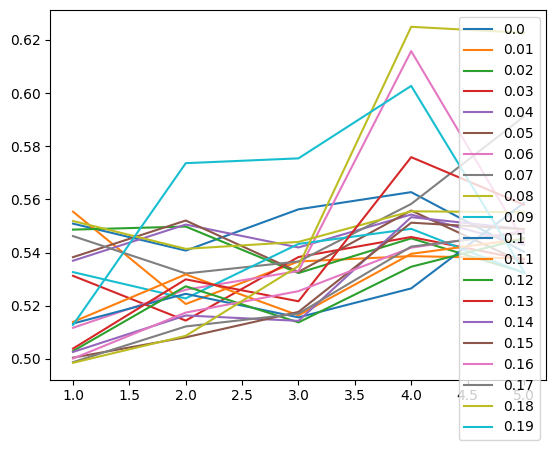

In [205]:
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split_data(X, y, random_state=i)

    try:
        X_resampled, y_resampled = balance_classes(X_train, y_train, k_neighbors=4)
    except ValueError:
        continue

    X_selected = select_features(pd.DataFrame(X_resampled), threshold = 0.02, info = False)
    column_names = X_selected.columns
    X_selected_test = X_test[column_names]

    print(f'\n{i}')
    clf = train_model(X_selected, y_resampled)
    y_pred = make_prediction(clf, X_selected_test)
    acc = evaluate_model(y_test, y_pred, show_cm=False)

## Model training

After numerous experiments, final parameters are set, and model is trained.

Classes distribution before sampling : [(0, 594), (1, 42), (2, 53), (3, 114), (4, 6), (5, 21), (6, 463), (7, 107), (8, 47)]
Classes distribution after sampling: [(0, 594), (1, 594), (2, 594), (3, 594), (4, 594), (5, 594), (6, 594), (7, 594), (8, 594)]
(5346, 167)
(5346, 112)
Balanced accuracy: 69.52%


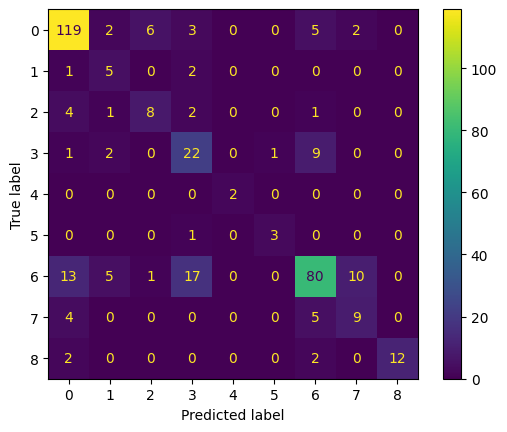

In [16]:
X_resampled, y_resampled = balance_classes(X_train, y_train, k_neighbors=2)

X_selected = select_features(pd.DataFrame(X_resampled), threshold = 0.06)
column_names = X_selected.columns
X_selected_test = X_test[column_names]

clf = train_model(X_selected, y_resampled,
                  bootstrap=False, max_features='sqrt',
                       min_samples_split=2, n_estimators=200)
y_pred = make_prediction(clf, X_selected_test)
acc = evaluate_model(y_test, y_pred)

# bootstrap=False, max_features='log2',
#                        min_samples_split=3, n_estimators=200

               #    bootstrap=False, max_features='log2',
               #         min_samples_split=5, n_estimators=300

## Making predictions

This section is dedicated for making predictions by final model and saving them in result file.

In [17]:
df = pd.read_csv('data/test.csv')
df.head()

,molecule_id,smiles
0,test_0,NC(=O)NN=Cc1ccc([N+](=O)[O-])o1
1,test_1,CCOC=O
2,test_2,CCOC(=O)C(Cc1c[nH]c2ccccc12)NC(=O)C1CCCN1C(=O)...
3,test_3,CC1=CCC(C(C)(C)OC(=O)c2ccccc2N)CC1
4,test_4,O=S(=O)([O-])Nc1nnc(-c2ccccc2Br)s1.[Na+]


In [18]:
maccs = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)) for x in df['smiles']]
maccs_lists = [list(l) for l in maccs]
maccs_name = [f'MACCS_{i}' for i in range(167)]

X = pd.DataFrame(maccs_lists, index=df.index, columns=maccs_name)

X = X[column_names]

model_predictions = clf.predict(X)

In [19]:
import csv
csv_file_path = f'./results/results_model_hyp_2_06_6.csv'

with open(csv_file_path, mode='w', newline='') as file:
    
    writer = csv.writer(file)
    file.write('molecule_id' + ',' + 'taste' + '\n')
    
    for i, pred in enumerate(model_predictions):
        file.write('test_' + str(i) + ',' + str(pred) + '\n')

print(f"CSV file '{csv_file_path}' created successfully!!!")

CSV file './results/results_model_hyp_2_06_6.csv' created successfully!!!
